In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout, LayerNorm, BatchNorm1d
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric as T
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv, global_mean_pool, global_add_pool, global_max_pool
from torch.nn.utils import clip_grad_norm_

import networkx as nx

from sklearn.metrics import roc_curve, roc_auc_score
from statistics import mean

In [2]:
# Read from csv
sig_df = pd.read_csv('Dijet_bb_pt20_50_dw.csv')
bkg_df = pd.read_csv('Dijet_qq_pt20_50_dw.csv')

In [3]:
# Distinguish signal and background
sig_df['IsB'] = 1
bkg_df['IsB'] = 0

# Separate Jet 0 and Jet 1 data
sig_jet0 = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsB")]]
bkg_jet0 = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsB")]]

#sig_jet1 = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet1|IsB")]]
#bkg_jet1 = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet1|IsB")]]

# Combine signal and background and shuffle
train_df = pd.concat([sig_jet0, bkg_jet0]).sample(frac=1, random_state=42).reset_index(drop=True)
#test_df = pd.concat([sig_jet1, bkg_jet1]).sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
list(train_df.columns)

['Jet0_ENDVERTEX_X',
 'Jet0_ENDVERTEX_Y',
 'Jet0_ENDVERTEX_Z',
 'Jet0_ENDVERTEX_XERR',
 'Jet0_ENDVERTEX_YERR',
 'Jet0_ENDVERTEX_ZERR',
 'Jet0_ENDVERTEX_CHI2',
 'Jet0_ENDVERTEX_NDOF',
 'Jet0_OWNPV_X',
 'Jet0_OWNPV_Y',
 'Jet0_OWNPV_Z',
 'Jet0_OWNPV_XERR',
 'Jet0_OWNPV_YERR',
 'Jet0_OWNPV_ZERR',
 'Jet0_OWNPV_CHI2',
 'Jet0_OWNPV_NDOF',
 'Jet0_IP_OWNPV',
 'Jet0_IPCHI2_OWNPV',
 'Jet0_FD_OWNPV',
 'Jet0_FDCHI2_OWNPV',
 'Jet0_DIRA_OWNPV',
 'Jet0_ORIVX_X',
 'Jet0_ORIVX_Y',
 'Jet0_ORIVX_Z',
 'Jet0_ORIVX_XERR',
 'Jet0_ORIVX_YERR',
 'Jet0_ORIVX_ZERR',
 'Jet0_ORIVX_CHI2',
 'Jet0_ORIVX_NDOF',
 'Jet0_FD_ORIVX',
 'Jet0_FDCHI2_ORIVX',
 'Jet0_DIRA_ORIVX',
 'Jet0_P',
 'Jet0_PT',
 'Jet0_PE',
 'Jet0_PX',
 'Jet0_PY',
 'Jet0_PZ',
 'Jet0_MM',
 'Jet0_MMERR',
 'Jet0_M',
 'Jet0_ID',
 'Jet0_Eta',
 'Jet0_Phi',
 'Jet0_MLoKi',
 'Jet0_MMLoKi',
 'Jet0_NTrk',
 'Jet0_N90',
 'Jet0_MTF',
 'Jet0_NSatCells',
 'Jet0_NHasPVInfo',
 'Jet0_JEC_Cor',
 'Jet0_JEC_PV',
 'Jet0_JEC_Error',
 'Jet0_w',
 'Jet0_CPF',
 'Jet0_JetWidth',
 'Je

In [5]:
# Calculate eta phi, and r for muons
def calc_eta_phi(df, px_col, py_col, pz_col):
    muon_eta = []
    muon_phi = []
    if train_df['Jet0_nmuons'].any() > 0:
        for i, row in df.iterrows():
            px = row[px_col]
            py = row[py_col]
            pz = row[pz_col]
            p_mag = np.sqrt(px**2 + py**2 + pz**2)
            eta = 0.5 * np.log((p_mag + pz) / (p_mag - pz))
            phi = np.arctan2(py, px)
            muon_eta.append(eta)
            muon_phi.append(phi)
    return muon_eta, muon_phi

def deltar(df, eta_col, phi_col):
    delta_r_values = []
    if train_df['Jet0_nmuons'].any() > 0:
        for i in range(len(df) - 1):
            eta1 = df.loc[i, eta_col]
            eta2 = df.loc[i + 1, eta_col]
            phi1 = df.loc[i, phi_col]
            phi2 = df.loc[i + 1, phi_col]
            delta_r = np.sqrt((eta2 - eta1)**2 + (phi2 - phi1)**2)
            delta_r_values.append(delta_r)
    
    delta_r_values.append(None) # for last row
    return delta_r_values

In [6]:
'''eta_values, phi_values = calc_eta_phi(train_df, 'Jet0_muon_PX', 'Jet0_muon_PY', 'Jet0_muon_PZ')
train_df['Jet0_muon_eta'] = eta_values
train_df['Jet0_muon_phi'] = phi_values

delta_r_values = deltar(train_df, 'Jet0_muon_eta', 'Jet0_muon_phi')
train_df['DeltaR'] = delta_r_values'''

"eta_values, phi_values = calc_eta_phi(train_df, 'Jet0_muon_PX', 'Jet0_muon_PY', 'Jet0_muon_PZ')\ntrain_df['Jet0_muon_eta'] = eta_values\ntrain_df['Jet0_muon_phi'] = phi_values\n\ndelta_r_values = deltar(train_df, 'Jet0_muon_eta', 'Jet0_muon_phi')\ntrain_df['DeltaR'] = delta_r_values"

In [7]:
# Truth matching
def truth_matching(train_df):
    
    train_df_sig = train_df[(train_df['IsB'] == 1) &
                            (train_df['Jet0_MC_Match'] == 1) &
                            (train_df['Jet0_MC_Jet_EfB'] > 0.6) &
                            (train_df['Jet0_PT'] > 20000) &
                            (train_df['Jet0_Eta'] > 2.2)  &
                            (train_df['Jet0_Eta'] < 4.4)]
    train_df_bkg = train_df[(train_df['IsB'] == 0) &
                            (train_df['Jet0_MC_Match'] == 1) &
                            (train_df['Jet0_MC_Jet_EfB'] < 0.6) &
                            (train_df['Jet0_MC_Jet_EfD'] < 0.6) &
                            (train_df['Jet0_PT'] > 20000) &
                            (train_df['Jet0_Eta'] > 2.2)  &
                            (train_df['Jet0_Eta'] < 4.4)]
    #test_df_sig = test_df[(test_df['IsB'] == 1) & (test_df['Jet1_MC_Match'] == 1) & (test_df['Jet1_MC_Jet_EfB'] > 0.6)]
    #test_df_bkg = test_df[(test_df['IsB'] == 0) & (test_df['Jet1_MC_Match'] == 1) & (test_df['Jet1_MC_Jet_EfB'] < 0.6) & (test_df['Jet1_MC_Jet_EfD'] < 0.6)]
    
    train_tm_df = pd.concat([train_df_sig, train_df_bkg], ignore_index=True)
    #test_cut_df = pd.concat([test_df_sig, test_df_bkg], ignore_index=True)
    return train_tm_df

# Duplicate data to lists matching the number of daughters/ nodes per jet/ row
def duplicate(df, cols, n_col):
    for col in cols:
        df[col] = df.apply(lambda row: [row[col]] * row[n_col] if isinstance(row[col], (float, int)) else row[col], axis=1)
    return df

# Convert string values into list of floats
def convert_to_lists(df, d_cols):
    for col in d_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

Data preprocessing

In [8]:
# Track/ daughter kinematic features
train_d_cols = [col for col in train_df.columns if "_Daughters" in col]
#test_d_cols = [col for col in test_df.columns if "_Daughters" in col]

# Jet input features
train_jet_cols = ['Jet0_Eta', 'Jet0_PT']
#test_jet_cols = ['Jet1_Eta', 'Jet1_PT']

# Features columns (daughter kinematics + jet inputs)
train_f_cols = train_d_cols + train_jet_cols
#test_f_cols = test_d_cols + test_jet_cols

# Truth matching
train_df = truth_matching(train_df)

# Duplicate single features for each node
train_df = duplicate(train_df, train_jet_cols, 'Jet0_nDaughters')
#test_df = duplicate(test_df, test_jet_cols, 'Jet1_nDaughters')

# Convert strings into float lists
train_df = convert_to_lists(train_df, train_d_cols)
#test_df = convert_to_lists(test_df, test_d_cols)

# Shuffle data
train_df = train_df.sample(frac=1).reset_index(drop=True)
#test_df = test_df.sample(frac=1).reset_index(drop=True)

In [9]:
train_df

,Jet0_ENDVERTEX_X,Jet0_ENDVERTEX_Y,Jet0_ENDVERTEX_Z,Jet0_ENDVERTEX_XERR,Jet0_ENDVERTEX_YERR,Jet0_ENDVERTEX_ZERR,Jet0_ENDVERTEX_CHI2,Jet0_ENDVERTEX_NDOF,Jet0_OWNPV_X,Jet0_OWNPV_Y,...,Jet0_Hlt1Phys_Dec,Jet0_Hlt1Phys_TIS,Jet0_Hlt1Phys_TOS,Jet0_Hlt2Global_Dec,Jet0_Hlt2Global_TIS,Jet0_Hlt2Global_TOS,Jet0_Hlt2Phys_Dec,Jet0_Hlt2Phys_TIS,Jet0_Hlt2Phys_TOS,IsB
0,0.8110,-0.1519,31.9685,0.0152,0.0127,0.1407,20.601074,49,0.810661,-0.152968,...,True,True,True,True,True,True,True,True,True,0
1,0.8339,-0.1810,-15.5543,0.0145,0.0146,0.1073,18.919027,39,0.810563,-0.202217,...,True,True,True,True,True,True,True,True,False,0
2,0.8741,-0.1987,-6.7329,0.0214,0.0208,0.0877,6.681668,13,0.826831,-0.192644,...,True,True,True,True,True,True,True,True,True,0
3,0.8689,-0.1620,99.8362,0.0083,0.0083,0.0541,51.527145,115,0.866908,-0.161656,...,True,True,True,True,True,True,True,True,True,1
4,0.8609,-0.1186,-14.7534,0.0073,0.0070,0.0407,81.940453,167,0.860962,-0.116483,...,False,False,False,True,False,False,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137087,0.8690,-0.2040,15.8952,0.0222,0.0205,0.1290,9.759695,19,0.818787,-0.147784,...,False,False,False,True,False,False,True,False,False,0
137088,0.7823,-0.2172,-16.5418,0.0127,0.0120,0.0799,20.908613,49,0.855176,-0.109338,...,True,True,True,True,True,True,True,True,True,0
137089,0.8406,-0.1877,69.8191,0.0079,0.0074,0.0412,60.420841,153,0.841768,-0.188367,...,True,True,True,True,True,True,True,True,True,1
137090,0.8518,-0.2015,1.7509,0.0128,0.0124,0.0541,27.246305,47,0.828285,-0.139722,...,True,True,True,True,True,True,True,True,False,0


In [10]:
sum(train_df.IsB.values)

69007

In [11]:
full_data = train_df.copy()

In [12]:
# Cut out some data for quicker runs
cut_train_df = full_data.head(24000) 
cut_test_df = full_data.head(6000)

In [13]:
# Pick which size data to feed into model
train_df = cut_train_df
test_df = cut_test_df

In [14]:
training_data = train_df[train_f_cols]
testing_data = test_df[train_f_cols]

In [15]:
training_data

,Jet0_Daughters_E,Jet0_Daughters_pT,Jet0_Daughters_ID,Jet0_Daughters_pX,Jet0_Daughters_pY,Jet0_Daughters_pZ,Jet0_Daughters_Eta,Jet0_Daughters_Phi,Jet0_Daughters_Q,Jet0_Daughters_IP,...,Jet0_Daughters_trackZ,Jet0_Daughters_trackVX,Jet0_Daughters_trackVY,Jet0_Daughters_trackVZ,Jet0_Daughters_CaloNeutralEcal,Jet0_Daughters_CaloNeutralHcal2Ecal,Jet0_Daughters_CaloNeutralE49,Jet0_Daughters_CaloNeutralPrs,Jet0_Eta,Jet0_PT
0,"[9041.669921875, 3955.630126953125, 6335.87011...","[477.02197265625, 89.84140014648438, 265.66348...","[22.0, -11.0, 22.0, 22.0, -211.0, -22.0, 211.0...","[469.28411865234375, 88.36930847167969, 262.99...","[85.57101440429688, 16.19697380065918, 37.5855...","[9029.078125, 3954.609619140625, 6330.29785156...","[3.6344871520996094, 4.477867603302002, 3.8644...","[0.18036217987537384, 0.18127524852752686, 0.1...","[0.0, 1.0, 0.0, 0.0, -1.0, 0.0, 1.0, 1.0]","[-100.0, -0.23293620347976685, -100.0, -100.0,...",...,"[-1000.0, -7.045199871063232, -1000.0, -1000.0...","[-1000.0, 88.36930847167969, -1000.0, -1000.0,...","[-1000.0, 16.19697380065918, -1000.0, -1000.0,...","[-1000.0, 3954.609619140625, -1000.0, -1000.0,...","[8681.2216796875, -1000.0, 5214.64794921875, 7...","[0.7147408127784729, -1000.0, 5.42164802551269...","[0.8809748888015747, -1000.0, 0.96885222196578...","[9.325239181518555, -1000.0, 57.59706878662109...","[4.063832081696572, 4.063832081696572, 4.06383...","[46575.0415877204, 46575.0415877204, 46575.041..."
1,"[2575.354736328125, 1407.6800537109375, 32158....","[673.6030883789062, 320.4569396972656, 5768.37...","[211.0, 22.0, -211.0, -22.0, -22.0, 22.0, -211...","[15.485214233398438, 50.11921691894531, 701.58...","[-673.425048828125, -316.51336669921875, -5725...","[2481.77978515625, 1370.7188720703125, 31637.0...","[2.0151655673980713, 2.159882068634033, 2.4032...","[-1.547805666923523, -1.4137524366378784, -1.4...","[1.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, 1.0, 1.0...","[0.06072264909744263, -100.0, 0.00011376983457...",...,"[2329.75, -1000.0, 23.801000595092773, -1000.0...","[15.485214233398438, -1000.0, 701.582214355468...","[-673.425048828125, -1000.0, -5725.55029296875...","[2481.77978515625, -1000.0, 31637.046875, -100...","[-1000.0, 1334.4793701171875, -1000.0, -1000.0...","[-1000.0, 0.0, -1000.0, -1000.0, -1000.0, 0.0,...","[-1000.0, 0.9517794251441956, -1000.0, -1000.0...","[-1000.0, 4.936891555786133, -1000.0, -1000.0,...","[2.3561006458088145, 2.3561006458088145, 2.356...","[29000.242750805748, 29000.242750805748, 29000..."
2,"[3545.85791015625, 16396.810546875, 5290.83984...","[307.4225158691406, 814.6232299804688, 369.146...","[211.0, 22.0, 22.0, 22.0, 211.0, -2212.0, 111....","[283.88739013671875, 779.1338500976562, 357.67...","[117.9684829711914, 237.8263702392578, 91.3120...","[3529.747802734375, 16376.5615234375, 5277.946...","[3.1357967853546143, 3.694645881652832, 3.3544...","[0.39383649826049805, 0.29626134037971497, 0.2...","[1.0, 0.0, 0.0, 0.0, 1.0, -1.0, 0.0, 1.0, 0.0,...","[0.15509270131587982, -100.0, -100.0, -100.0, ...",...,"[2329.75, -1000.0, -1000.0, -1000.0, -20.00499...","[283.88739013671875, -1000.0, -1000.0, -1000.0...","[117.9684829711914, -1000.0, -1000.0, -1000.0,...","[3529.747802734375, -1000.0, -1000.0, -1000.0,...","[-1000.0, 16528.28125, 5570.06201171875, -1000...","[-1000.0, 0.11727165430784225, 0.3467684686183...","[-1000.0, 0.912543773651123, 0.815318763256073...","[-1000.0, 24.135913848876953, 6.85679388046264...","[3.52939824682104, 3.52939824682104, 3.5293982...","[21961.17602264248, 21961.17602264248, 21961.1..."
3,"[14345.94921875, 1197.81396484375, 2122.270019...","[1064.05859375, 98.91680145263672, 327.1599731...","[211.0, 22.0, 22.0, 211.0, -321.0, -211.0, -21...","[-854.7694091796875, -82.49922180175781, -282....","[-633.711181640625, -54.5748291015625, -164.68...","[14305.751953125, 1193.72265625, 2096.90161132...","[3.2930986881256104, 3.1854121685028076, 2.556...","[-2.503629446029663, -2.557162046432495, -2.61...","[1.0, 0.0, 0.0, 1.0, -1.0, -1.0

In [16]:
testing_data

,Jet0_Daughters_E,Jet0_Daughters_pT,Jet0_Daughters_ID,Jet0_Daughters_pX,Jet0_Daughters_pY,Jet0_Daughters_pZ,Jet0_Daughters_Eta,Jet0_Daughters_Phi,Jet0_Daughters_Q,Jet0_Daughters_IP,...,Jet0_Daughters_trackZ,Jet0_Daughters_trackVX,Jet0_Daughters_trackVY,Jet0_Daughters_trackVZ,Jet0_Daughters_CaloNeutralEcal,Jet0_Daughters_CaloNeutralHcal2Ecal,Jet0_Daughters_CaloNeutralE49,Jet0_Daughters_CaloNeutralPrs,Jet0_Eta,Jet0_PT
0,"[9041.669921875, 3955.630126953125, 6335.87011...","[477.02197265625, 89.84140014648438, 265.66348...","[22.0, -11.0, 22.0, 22.0, -211.0, -22.0, 211.0...","[469.28411865234375, 88.36930847167969, 262.99...","[85.57101440429688, 16.19697380065918, 37.5855...","[9029.078125, 3954.609619140625, 6330.29785156...","[3.6344871520996094, 4.477867603302002, 3.8644...","[0.18036217987537384, 0.18127524852752686, 0.1...","[0.0, 1.0, 0.0, 0.0, -1.0, 0.0, 1.0, 1.0]","[-100.0, -0.23293620347976685, -100.0, -100.0,...",...,"[-1000.0, -7.045199871063232, -1000.0, -1000.0...","[-1000.0, 88.36930847167969, -1000.0, -1000.0,...","[-1000.0, 16.19697380065918, -1000.0, -1000.0,...","[-1000.0, 3954.609619140625, -1000.0, -1000.0,...","[8681.2216796875, -1000.0, 5214.64794921875, 7...","[0.7147408127784729, -1000.0, 5.42164802551269...","[0.8809748888015747, -1000.0, 0.96885222196578...","[9.325239181518555, -1000.0, 57.59706878662109...","[4.063832081696572, 4.063832081696572, 4.06383...","[46575.0415877204, 46575.0415877204, 46575.041..."
1,"[2575.354736328125, 1407.6800537109375, 32158....","[673.6030883789062, 320.4569396972656, 5768.37...","[211.0, 22.0, -211.0, -22.0, -22.0, 22.0, -211...","[15.485214233398438, 50.11921691894531, 701.58...","[-673.425048828125, -316.51336669921875, -5725...","[2481.77978515625, 1370.7188720703125, 31637.0...","[2.0151655673980713, 2.159882068634033, 2.4032...","[-1.547805666923523, -1.4137524366378784, -1.4...","[1.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, 1.0, 1.0...","[0.06072264909744263, -100.0, 0.00011376983457...",...,"[2329.75, -1000.0, 23.801000595092773, -1000.0...","[15.485214233398438, -1000.0, 701.582214355468...","[-673.425048828125, -1000.0, -5725.55029296875...","[2481.77978515625, -1000.0, 31637.046875, -100...","[-1000.0, 1334.4793701171875, -1000.0, -1000.0...","[-1000.0, 0.0, -1000.0, -1000.0, -1000.0, 0.0,...","[-1000.0, 0.9517794251441956, -1000.0, -1000.0...","[-1000.0, 4.936891555786133, -1000.0, -1000.0,...","[2.3561006458088145, 2.3561006458088145, 2.356...","[29000.242750805748, 29000.242750805748, 29000..."
2,"[3545.85791015625, 16396.810546875, 5290.83984...","[307.4225158691406, 814.6232299804688, 369.146...","[211.0, 22.0, 22.0, 22.0, 211.0, -2212.0, 111....","[283.88739013671875, 779.1338500976562, 357.67...","[117.9684829711914, 237.8263702392578, 91.3120...","[3529.747802734375, 16376.5615234375, 5277.946...","[3.1357967853546143, 3.694645881652832, 3.3544...","[0.39383649826049805, 0.29626134037971497, 0.2...","[1.0, 0.0, 0.0, 0.0, 1.0, -1.0, 0.0, 1.0, 0.0,...","[0.15509270131587982, -100.0, -100.0, -100.0, ...",...,"[2329.75, -1000.0, -1000.0, -1000.0, -20.00499...","[283.88739013671875, -1000.0, -1000.0, -1000.0...","[117.9684829711914, -1000.0, -1000.0, -1000.0,...","[3529.747802734375, -1000.0, -1000.0, -1000.0,...","[-1000.0, 16528.28125, 5570.06201171875, -1000...","[-1000.0, 0.11727165430784225, 0.3467684686183...","[-1000.0, 0.912543773651123, 0.815318763256073...","[-1000.0, 24.135913848876953, 6.85679388046264...","[3.52939824682104, 3.52939824682104, 3.5293982...","[21961.17602264248, 21961.17602264248, 21961.1..."
3,"[14345.94921875, 1197.81396484375, 2122.270019...","[1064.05859375, 98.91680145263672, 327.1599731...","[211.0, 22.0, 22.0, 211.0, -321.0, -211.0, -21...","[-854.7694091796875, -82.49922180175781, -282....","[-633.711181640625, -54.5748291015625, -164.68...","[14305.751953125, 1193.72265625, 2096.90161132...","[3.2930986881256104, 3.1854121685028076, 2.556...","[-2.503629446029663, -2.557162046432495, -2.61...","[1.0, 0.0, 0.0, 1.0, -1.0, -1.0

In [17]:
cut_train_df.IsB

0        0
1        0
2        0
3        1
4        1
        ..
23995    0
23996    0
23997    0
23998    0
23999    1
Name: IsB, Length: 24000, dtype: int64

In [18]:
cut_test_df.IsB

0       0
1       0
2       0
3       1
4       1
       ..
5995    0
5996    1
5997    1
5998    1
5999    1
Name: IsB, Length: 6000, dtype: int64

In [19]:
# Create node feature array: [jet][daughter][feature]
def node_features(df, features_cols):
    features_list = []
    
    for _, row in df.iterrows():

        max_nodes = max(len(row[col]) if isinstance(row[col], list) else 1 for col in features_cols)
        jet_nodes = [[] for _ in range(max_nodes)]
        
        for column in features_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(max_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    return np.array(features_list, dtype=object)

# Create graphs for each jet - orig
def create_data_objects(df, features_array):
    data_objects = []
    for idx, features in enumerate(features_array):

        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)
        num_classes = 2 # binary classification

        # Fully connected edges
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        y = torch.tensor([df['IsB'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_classes=num_classes, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Extract node features
train_features = node_features(train_df, train_f_cols)
test_features = node_features(test_df, train_f_cols)

# Create graphs for each jet
train_data = create_data_objects(train_df, train_features)
test_data = create_data_objects(test_df, test_features)

# Load Data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [20]:
# Define GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 64
        self.conv1 = GCNConv(len(train_f_cols), hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm1d(hidden_channels)
        self.lin = Linear(hidden_channels, 1)
        self.dropout = torch.nn.Dropout(0.1)

    def forward(self, x, edge_index, batch):
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)
        x1 = self.dropout(x1)

        x2 = self.conv2(x1, edge_index) + x1
        x2 = self.bn2(x2)
        x2 = F.relu(x2)
        x2 = self.dropout(x2)

        x3 = self.conv3(x2, edge_index) + x2
        x3 = self.bn3(x3)
        x3 = F.relu(x3)
        x3 = self.dropout(x3)

        x = global_mean_pool(x3, batch)
        x = self.lin(x)
        return x.squeeze(1)

model = GNN()

# Define optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
criterion = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) # decrease lr every 10 epochs by 0.1

# Training loop
def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y.float())
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    scheduler.step()
        
    return total_loss / len(train_loader.dataset)

# Testing function
def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            pred = (out > 0).float()
            correct = (pred.squeeze() == data.y.float()).sum().item()
            total_correct += correct
            total_samples += len(data.y)
    
    return total_correct / total_samples

# Check gradients
def check_gradients():
    model.train()
    data = next(iter(train_loader))
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.batch)
    loss = criterion(out.squeeze(-1), data.y.float())
    loss.backward()

    print(' ')
    print('Grad norms:')
    for name, param in model.named_parameters():
        if param.requires_grad:
            if param.grad is not None:
                grad_norm = param.grad.norm().item()
                print(f"    {name}: {grad_norm:.6f}")

# Training parameters
num_epochs = 200

# Lists to store loss and accuracy values
loss_values = []
train_acc_values = []
test_acc_values = []

# Training loop
for epoch in range(num_epochs):
    loss = train()
    loss_values.append(loss)
    train_acc = test(train_loader)
    train_acc_values.append(train_acc)
    test_acc = test(test_loader)
    test_acc_values.append(test_acc)

    print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Check gradients after training
check_gradients()

Epoch: 001, Loss: 0.6947, Train Acc: 0.5138, Test Acc: 0.5218
Epoch: 002, Loss: 0.6931, Train Acc: 0.5354, Test Acc: 0.5327
Epoch: 003, Loss: 0.6928, Train Acc: 0.5368, Test Acc: 0.5418
Epoch: 004, Loss: 0.6925, Train Acc: 0.5304, Test Acc: 0.5302
Epoch: 005, Loss: 0.6931, Train Acc: 0.5208, Test Acc: 0.5252
Epoch: 006, Loss: 0.6924, Train Acc: 0.5360, Test Acc: 0.5420
Epoch: 007, Loss: 0.6923, Train Acc: 0.5365, Test Acc: 0.5450
Epoch: 008, Loss: 0.6916, Train Acc: 0.5292, Test Acc: 0.5368
Epoch: 009, Loss: 0.6917, Train Acc: 0.5378, Test Acc: 0.5460
Epoch: 010, Loss: 0.6921, Train Acc: 0.5283, Test Acc: 0.5352
Epoch: 011, Loss: 0.6908, Train Acc: 0.5347, Test Acc: 0.5418
Epoch: 012, Loss: 0.6907, Train Acc: 0.5367, Test Acc: 0.5355
Epoch: 013, Loss: 0.6898, Train Acc: 0.5400, Test Acc: 0.5445
Epoch: 014, Loss: 0.6894, Train Acc: 0.5361, Test Acc: 0.5438
Epoch: 015, Loss: 0.6899, Train Acc: 0.5382, Test Acc: 0.5372
Epoch: 016, Loss: 0.6901, Train Acc: 0.5350, Test Acc: 0.5373
Epoch: 0

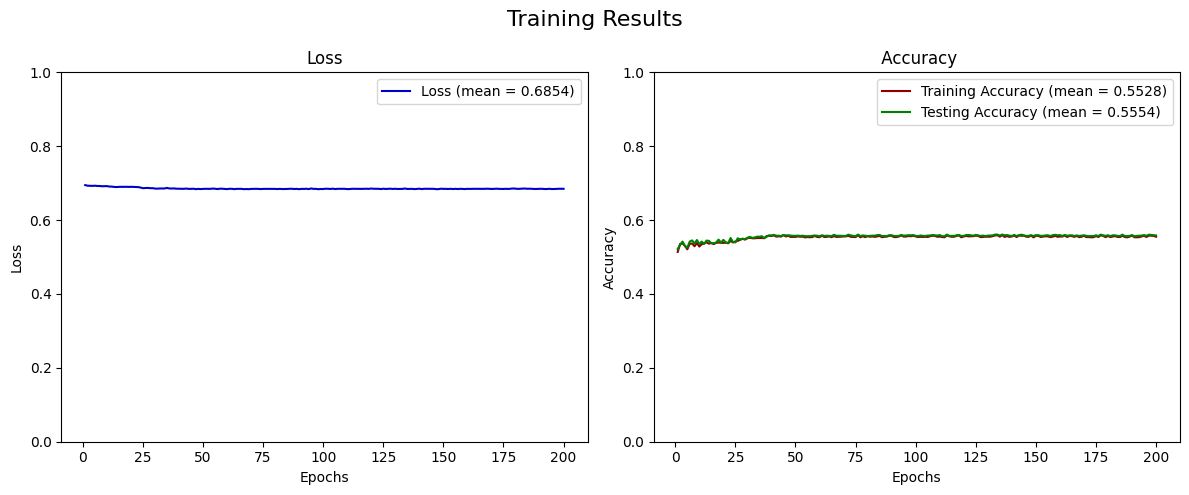

In [21]:
# Plot Loss and Accuracy
def plot_training_results(loss_values, train_acc_values, test_acc_values):
    epochs = range(1, len(loss_values) + 1)  # Create a list of epoch numbers
    mean_train_acc = mean(train_acc_values)
    mean_test_acc = mean(test_acc_values)
    mean_loss = mean(loss_values)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Training Results', fontsize=16)

    # Plot Loss
    ax1.plot(epochs, loss_values, color='mediumblue', label=(f"Loss (mean = {mean_loss:.4f})"))
    ax1.set_ylim(0, 1)
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # Plot  Accuracy
    ax2.plot(epochs, train_acc_values, color='darkred', label=(f"Training Accuracy (mean = {mean_train_acc:.4f})"))
    ax2.plot(epochs, test_acc_values, color='green', label=(f"Testing Accuracy (mean = {mean_test_acc:.4})"))
    ax2.set_ylim(0, 1)
    ax2.set_title(' Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    plt.tight_layout()
    plt.show()

# After your training loop, call the function:
plot_training_results(loss_values, train_acc_values, test_acc_values)

Compute ROC Curve and AUC

In [22]:
# Get model predictions
y_true = []  # class values (0 or 1)
y_scores = []  # predicted probabilities or scores

model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch)
        prob = torch.sigmoid(out)
        
        y_true.append(data.y.numpy().flatten())
        y_scores.append(prob.numpy().flatten())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

In [23]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

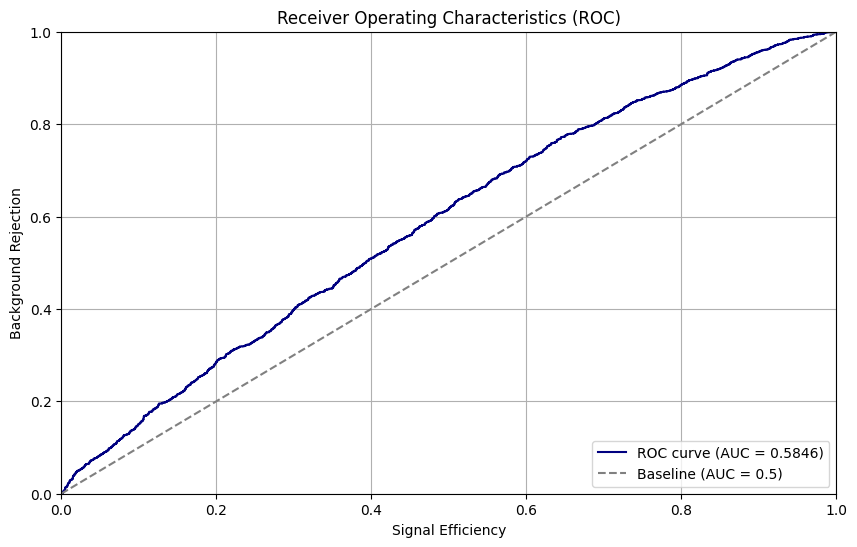

In [24]:
# Plot ROC Curve and show AUC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Background Rejection')
plt.xlabel('Signal Efficiency')
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Analyze strength of features

       Feature    Importance
0    Feature_0  6.782016e-02
1    Feature_1  7.915442e-04
2    Feature_2  4.304282e-06
3    Feature_3  6.338733e-05
4    Feature_4  4.117901e-06
5    Feature_5  7.987499e-02
6    Feature_6  4.091999e-08
7    Feature_7  0.000000e+00
8    Feature_8  1.862645e-09
9    Feature_9  1.750712e-06
10  Feature_10  2.163361e-02
11  Feature_11  1.240929e-06
12  Feature_12  1.192759e-04
13  Feature_13  1.192889e-04
14  Feature_14  1.193426e-04
15  Feature_15  1.192340e-04
16  Feature_16  1.184022e-04
17  Feature_17  1.191756e-04
18  Feature_18  1.006487e-04
19  Feature_19  1.169393e-04
20  Feature_20  1.240348e-04
21  Feature_21  8.926704e-05
22  Feature_22  4.707056e-05
23  Feature_23  1.516503e-04
24  Feature_24  4.146281e-02
25  Feature_25  1.041330e-02
26  Feature_26  5.690951e-05
27  Feature_27  5.738495e-05
28  Feature_28  4.458212e-05
29  Feature_29  6.757909e-08
30  Feature_30  3.619402e-02


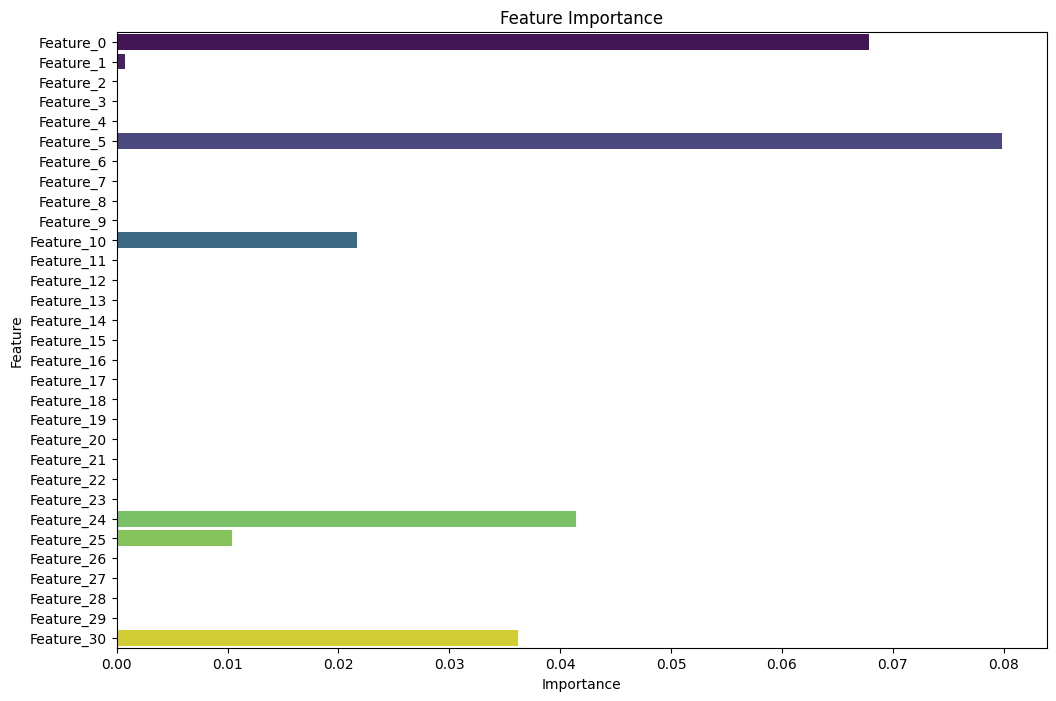

In [25]:
import seaborn as sns

# Ensure model is in evaluation mode
model.eval()

# Prepare a sample batch for explanation
data = next(iter(test_loader))  # Adjust if necessary
x, edge_index, batch = data.x, data.edge_index, data.batch

# Convert edge_index to NetworkX graph
G = nx.Graph()
edges = list(zip(edge_index[0].numpy(), edge_index[1].numpy()))
G.add_edges_from(edges)

# Initialize placeholders for feature importance
feature_importances = np.zeros(x.size(1))

# Compute importance for each feature
for feature_idx in range(x.size(1)):
    # Perturb the feature by setting it to zero
    x_perturbed = x.clone()
    x_perturbed[:, feature_idx] = 0

    # Predict with original features
    with torch.no_grad():
        orig_pred = model(x, edge_index, batch)
        perturbed_pred = model(x_perturbed, edge_index, batch)

    # Importance is computed as the difference in predictions
    importance = torch.mean(torch.abs(orig_pred - perturbed_pred)).item()
    feature_importances[feature_idx] = importance

# Convert to DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': [f'Feature_{i}' for i in range(x.size(1))],
    'Importance': feature_importances})

# Print feature importances
print(importance_df)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', hue='Feature', dodge=False)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [26]:
for i, col in enumerate(train_f_cols, start=0):
    print(f"{i}. {col}")

0. Jet0_Daughters_E
1. Jet0_Daughters_pT
2. Jet0_Daughters_ID
3. Jet0_Daughters_pX
4. Jet0_Daughters_pY
5. Jet0_Daughters_pZ
6. Jet0_Daughters_Eta
7. Jet0_Daughters_Phi
8. Jet0_Daughters_Q
9. Jet0_Daughters_IP
10. Jet0_Daughters_IPCHI2
11. Jet0_Daughters_IPraw
12. Jet0_Daughters_NNe
13. Jet0_Daughters_NNk
14. Jet0_Daughters_NNp
15. Jet0_Daughters_NNpi
16. Jet0_Daughters_NNmu
17. Jet0_Daughters_Chi2
18. Jet0_Daughters_QoverP
19. Jet0_Daughters_trackX
20. Jet0_Daughters_trackY
21. Jet0_Daughters_trackZ
22. Jet0_Daughters_trackVX
23. Jet0_Daughters_trackVY
24. Jet0_Daughters_trackVZ
25. Jet0_Daughters_CaloNeutralEcal
26. Jet0_Daughters_CaloNeutralHcal2Ecal
27. Jet0_Daughters_CaloNeutralE49
28. Jet0_Daughters_CaloNeutralPrs
29. Jet0_Eta
30. Jet0_PT
